# Hisenberg VQE

A jupyter notebook version of HVQE code, you just run it with `Shift`+`Enter`!

## Environment Requirement

Needed package list:

- cupy
- chainer
- scipy
- matplotlib, numpy

In [1]:
import qem
import _HVQE
from time import time
import os,sys,pickle
import chainer as ch 
import numpy as np
from datetime import datetime

CuPy installation found, continuing using GPU acceleration.


In [2]:
# Definations
job_name = "chain_10"     # choices: kagome_open, kagome_periodic, triangular, test
input_graph = "./input/graph_input_%s.txt"%job_name
output_path = "./output/"+job_name
k = 10       # Number of lowest energy eigenstates



if not os.path.exists(output_path):
    os.mkdir(output_path)

In [3]:
return_state=True


with open(input_graph, 'r') as file:
    exec(file.read())
    
complete_graph=complete_graph_input
del complete_graph_input

In [4]:
# Run ground state
print('')
print('--------------------------------------------------')
print('Computing the', k, 'lowest energies of',job_name)
start=time()
output=qem.ground_state(complete_graph,k,return_state)
if qem.GPU==True: qem.sync()
end=time()
if return_state==False:
    print('The', k, 'lowest energies are', output)
if return_state==True:
    print('The', k, 'lowest energies are', output[0])
print('Solutions found using using ARPACK, in a total of', end-start, 'seconds')
print('--------------------------------------------------')
print(' ')


--------------------------------------------------
Computing the 10 lowest energies of chain_10
The 10 lowest energies are [-4.51544635 -4.09220735 -4.09220735 -4.09220735 -3.77059744 -3.54327937
 -3.54327937 -3.54327937 -3.54327937 -3.54327937]
Solutions found using using ARPACK, in a total of 2.4591262340545654 seconds
--------------------------------------------------
 


In [5]:
return_state=True

## Write gs energy to disk
if return_state==False:
    np.savetxt(output_path+'/lowest_energies.txt',output)
else:
    np.savetxt(output_path+'/lowest_energies.txt',output[0])
    # Write gs itself to disk if return_state is True
    with open(output_path+'/gs.dat', 'wb') as file:
        pickle.dump(output[1][:,0],file,protocol=4)

In [6]:
class Name:
    pass

class Parameters:
    pass

# cmd_args=_HVQE.get_command_line_input()
run_args=Name()
cmd_args=Parameters()
cmd_args.n_par = 30            # number of parameters to be used in the VQE
cmd_args.par_multiplicity = 1  # The parameter multiplicity
cmd_args.n_iter = 1            # Number of iterations of the basinhopping routine
cmd_args.cost_fn = 'energy'    # or 'infidelity'
cmd_args.temperature = 1.      # Temperature for the metropolis creterion in the scipy basinhopping routine
cmd_args.stepsize = 1.         # max stepsize of random displacement per parameter after each local optimization in the scipy basinhopping routine
cmd_args.init_par = None       # A list of initial parameters from which the basinhopping routine starts
cmd_args.dump_interval = None  # Dump the state of the program to path/dump.dat every dump_interval function calls

In [7]:
try: # Use GPU if CuPy installation is available. 
    import cupy as xp
    run_args.GPU=True
except ImportError:
    import numpy as xp
    run_args.GPU=False

# Make timestamp in UTC of start
run_args.date_start=str(datetime.utcnow())

In [8]:
# Load the ansatz from graph_input.txt
with open(input_graph, 'r') as file:
    exec(file.read())
run_args.complete_graph=complete_graph_input
run_args.init_layer=init_layer_input
run_args.layers =layers_input
del complete_graph_input
del init_layer_input
del layers_input

# Get the number of qubits from the complete_graph.
nodes=[node for edge in run_args.complete_graph for node in edge]
nodes=set(nodes)
run_args.n=len(nodes)
del nodes

In [9]:
# Load the true ground state into memory for computation of infidelities. 
gs_reg=qem.Reg(run_args.n)
with open(output_path+'/gs.dat','rb') as file:
    gs_reg.psi.re=xp.array(pickle.load(file)).reshape((2,)*run_args.n)  

# Print info about current run to stdout.    
print('Started basinhopping at',run_args.date_start, 'UTC')

Started basinhopping at 2021-12-19 09:52:18.699887 UTC


In [10]:
# Prepare the init_reg, whose state is a dimer covering of run_args.complete_graph, as specified by run_args.init_layer.
init_reg=qem.Reg(run_args.n)   
for edge in run_args.init_layer:
    qem.apply_prepare_singlet(edge,init_reg)

In [11]:
#RUN THE VQE
run_args.start=time()

global reg_psi_list
reg_psi_list = []

global reg_psi
reg_psi = None

vqe_out,reg_psi=_HVQE.run_VQE(cmd_args,run_args,init_reg,gs_reg,reg_psi_list)
reg_psi_list.append(reg_psi)

if run_args.GPU==True:
    qem.sync()
run_args.end=time() 
# Wall-clock time of VQE (hours) 
run_args.wall_clock=(run_args.end-run_args.start)/60/60 


................................................................................................................................................................................................................................
New local min for {'n_par': 30, 'par_multiplicity': 1, 'n_iter': 1, 'cost_fn': 'energy', 'temperature': 1.0, 'stepsize': 1.0, 'init_par': None, 'dump_interval': None}
cost= -4.503763569919035 accepted= True parameters= [0.09783364475892735, -2.3504714997424148, -1.2125973380558401, -0.8998409372291543, -0.3934698547563028, -2.8583297479269922, -2.285549688150928, 1.7474512666045974, -0.05604775416680963, -0.36183560598894215, -1.9614146317501282, 1.6240325164186025, -0.16789935167565986, 1.2933476664049595, -0.38710607129676333, -2.729503123031223, -0.7304306374951278, 0.385050192202262, -1.79603398051288, 1.1287906571647808, -1.483914450465724, -0.4222099487876814, -0.31705646528468273, -1.3898539461995176, -0.3878070169891705, -0.2506027086038359, 0.1363918051660

In [12]:
# Get the infidelity and the energy of the final state irrespective of whether we used the energy or the infidelity as the cost functon.
vqe_out.opt_parameters=ch.Variable(xp.array(vqe_out.opt_parameters))
if cmd_args.cost_fn=='energy':
    run_args.E_VQE=vqe_out.cost_VQE #Already a float
    run_args.inf_VQE=_HVQE.infidelity_from_parameters(init_reg,run_args.layers,run_args.n,cmd_args.par_multiplicity,vqe_out.opt_parameters,gs_reg)
    run_args.inf_VQE=float(run_args.inf_VQE.array)
if cmd_args.cost_fn=='infidelity':
    run_args.inf_VQE=vqe_out.cost_VQE #Already a float
    run_args.E_VQE,reg_psi=_HVQE.Heisenberg_energy_from_parameters(run_args.complete_graph,init_reg,run_args.layers,run_args.n,cmd_args.par_multiplicity,vqe_out.opt_parameters)
    run_args.E_VQE=float(run_args.E_VQE.array)

vqe_out.opt_parameters=vqe_out.opt_parameters.array.tolist() #Convert for printing and storing.
run_args.date_end=str(datetime.utcnow()) # End time in UTC


# Write input and results to disk. If no former output exists, print a line explaining the data in the output file.

output=str([vars(cmd_args),vars(run_args),vars(vqe_out)])

if not os.path.exists(output_path+'/output_ground.txt'):
    f=open(output_path+'/output_ground.txt', 'w')
    f.write("### Output of the VQEs is written to this file. Note that the first local minimum is not included in the lists local_min_list,local_min_parameters_list and local_min_accept_list. See the comment at de function definition of 'callback' inside HVQE.py \n")
with open(output_path+'/output_ground.txt', 'a') as f:
    f.write(output+'\n\n')

print(' ')
print('==========================================================================================')
print('Finished basinhopping of ',output_path, 'at',run_args.date_end,'UTC, with')
print(' ')
print(vars(cmd_args))
print('init_par =', vqe_out.init_par)
print(' ')
print('RESULTS:')
print('--------')
print('E_VQE =',run_args.E_VQE)
print('inf_VQE =',run_args.inf_VQE)
print('n_fn_calls =',vqe_out.n_fn_calls)
print('Wall-clock time', run_args.wall_clock, 'hours')
print(' ')
print('For more output, see',output_path+'/output.txt')
print('Plots of output saved in',output_path)
print('End of HVQE.py')
print('==========================================================================================')

 
Finished basinhopping of  ./output/chain_10 at 2021-12-19 09:54:29.743201 UTC, with
 
{'n_par': 30, 'par_multiplicity': 1, 'n_iter': 1, 'cost_fn': 'energy', 'temperature': 1.0, 'stepsize': 1.0, 'init_par': None, 'dump_interval': None}
init_par = [-0.0004357176818871075, -9.921974386854185e-05, 2.310061832489082e-05, 0.0004862562506384022, 7.913402079173652e-05, 0.00015446400477489022, -0.0003250563324285214, 1.0475242969254332e-06, -0.0001626570877016409, -0.00046921688591861565, -2.2229271413807248e-05, -0.0004865066260163775, 0.0003171647225929669, -0.00015146581790133784, 0.0004891702243101077, 8.688114458075397e-05, 0.00041074081993068394, -0.0003777603441598987, -0.00020720721371171792, 0.00024663432005991815, -0.0002466314912237053, -0.0003950212770693196, -0.00033552168890819923, -0.00037172607807272885, 0.0003225499929728641, -0.0003499312528315501, -0.0002640789186457975, -0.0003346091583100437, -0.00023835792879619243, -0.00039359359349841683]
 
RESULTS:
--------
E_VQE = -4

In [13]:
#RUN THE VQE
run_args.start=time()

vqe_out,reg_psi=_HVQE.run_VQE(cmd_args,run_args,init_reg,gs_reg,reg_psi_list)
reg_psi_list.append(reg_psi)

if run_args.GPU==True:
    qem.sync()
run_args.end=time() 
# Wall-clock time of VQE (hours) 
run_args.wall_clock=(run_args.end-run_args.start)/60/60 


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
New local min for {'n_par': 30, 'par_multiplicity': 1, 'n_iter': 1, 'cost_fn': 'energy', 'temperature': 1.0, 'stepsize': 1.0, 'init_par': None, 'dump_interval': None}
cost= -3.699114655736661 accepted= True parameters= [4.698296479860963, -0.7885909023089354, 0.0274855729449182, -1.8012313864931344, 1.4014401047493295, 3.3311754554798196, 1.6702006259136066, -0.920247378708893, 3.7957969963116507

In [14]:
# Get the infidelity and the energy of the final state irrespective of whether we used the energy or the infidelity as the cost functon.
vqe_out.opt_parameters=ch.Variable(xp.array(vqe_out.opt_parameters))
if cmd_args.cost_fn=='energy':
    run_args.E_VQE=vqe_out.cost_VQE #Already a float
    run_args.inf_VQE=_HVQE.infidelity_from_parameters(init_reg,run_args.layers,run_args.n,cmd_args.par_multiplicity,vqe_out.opt_parameters,gs_reg)
    run_args.inf_VQE=float(run_args.inf_VQE.array)
if cmd_args.cost_fn=='infidelity':
    run_args.inf_VQE=vqe_out.cost_VQE #Already a float
    run_args.E_VQE,reg_psi=_HVQE.Heisenberg_energy_from_parameters(run_args.complete_graph,init_reg,run_args.layers,run_args.n,cmd_args.par_multiplicity,vqe_out.opt_parameters)
    run_args.E_VQE=float(run_args.E_VQE.array)

vqe_out.opt_parameters=vqe_out.opt_parameters.array.tolist() #Convert for printing and storing.
run_args.date_end=str(datetime.utcnow()) # End time in UTC


# Write input and results to disk. If no former output exists, print a line explaining the data in the output file.

output=str([vars(cmd_args),vars(run_args),vars(vqe_out)])

if not os.path.exists(output_path+'/output_excite1.txt'):
    f=open(output_path+'/output_excite1.txt', 'w')
    f.write("### Output of the VQEs is written to this file. Note that the first local minimum is not included in the lists local_min_list,local_min_parameters_list and local_min_accept_list. See the comment at de function definition of 'callback' inside HVQE.py \n")
with open(output_path+'/output_excite1.txt', 'a') as f:
    f.write(output+'\n\n')

print(' ')
print('==========================================================================================')
print('Finished basinhopping of ',output_path, 'at',run_args.date_end,'UTC, with')
print(' ')
print(vars(cmd_args))
print('init_par =', vqe_out.init_par)
print(' ')
print('RESULTS:')
print('--------')
print('E_VQE =',run_args.E_VQE)
print('inf_VQE =',run_args.inf_VQE)
print('n_fn_calls =',vqe_out.n_fn_calls)
print('Wall-clock time', run_args.wall_clock, 'hours')
print(' ')
print('For more output, see',output_path+'/output.txt')
print('Plots of output saved in',output_path)
print('End of HVQE.py')
print('==========================================================================================')

 
Finished basinhopping of  ./output/chain_10 at 2021-12-19 09:58:45.135832 UTC, with
 
{'n_par': 30, 'par_multiplicity': 1, 'n_iter': 1, 'cost_fn': 'energy', 'temperature': 1.0, 'stepsize': 1.0, 'init_par': None, 'dump_interval': None}
init_par = [-0.0004818769532590598, 0.000488027881060974, 0.00018009717934709376, -4.1470870679582246e-05, 4.73941089436001e-06, -0.0004918081570738314, -0.0003389948665584697, 0.0004092405364429265, 0.0004424573861797113, -7.726240932974017e-05, 0.00016025928482010148, -0.0004184641470363396, 0.0003900035988307711, 0.00017430310336540044, -0.00044647611805821177, -0.00026177556591358987, -5.437541229018762e-05, -2.423455678595435e-05, 0.0002621670849990218, 0.00044848540909872645, -0.00027353228208043914, 0.0003687407701256076, -0.00042585721517274645, -0.00023395022856052827, -6.076548498672532e-05, 0.00013368874145042132, -0.0004527650751712008, -0.000493677808508928, -8.595658569027144e-05, 0.0002839059655191788]
 
RESULTS:
--------
E_VQE = -3.69911

In [15]:
#RUN THE VQE
run_args.start=time()

vqe_out,reg_psi=_HVQE.run_VQE(cmd_args,run_args,init_reg,gs_reg,reg_psi_list)
reg_psi_list.append(reg_psi)

if run_args.GPU==True:
    qem.sync()
run_args.end=time() 
# Wall-clock time of VQE (hours) 
run_args.wall_clock=(run_args.end-run_args.start)/60/60 


...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
New local min for {'n_par': 30, 'par_multiplicity': 1, 'n_iter': 1, 'cost_fn': 'energy', 'temperature': 1.0, 'stepsize': 1.0, 'init_par': None, 'dump_interval': None}
cost= -2.828516493196111 accepted= True parameters= [1.5729571953408616, -4.264397270388386, 6.245536697999002, 8.989603967474903, -1.3107753591784628, -1.6315155378597235, -3.7072502364787967, 3.65393240076804, 2.673033495938002, -3.3369363266501355, -3.113389717763795, -3.4313355205801814, 9.000436047022886, 7.140249394706167, 0.0384419142067810

In [16]:
# Get the infidelity and the energy of the final state irrespective of whether we used the energy or the infidelity as the cost functon.
vqe_out.opt_parameters=ch.Variable(xp.array(vqe_out.opt_parameters))
if cmd_args.cost_fn=='energy':
    run_args.E_VQE=vqe_out.cost_VQE #Already a float
    run_args.inf_VQE=_HVQE.infidelity_from_parameters(init_reg,run_args.layers,run_args.n,cmd_args.par_multiplicity,vqe_out.opt_parameters,gs_reg)
    run_args.inf_VQE=float(run_args.inf_VQE.array)
if cmd_args.cost_fn=='infidelity':
    run_args.inf_VQE=vqe_out.cost_VQE #Already a float
    run_args.E_VQE,reg_psi=_HVQE.Heisenberg_energy_from_parameters(run_args.complete_graph,init_reg,run_args.layers,run_args.n,cmd_args.par_multiplicity,vqe_out.opt_parameters)
    run_args.E_VQE=float(run_args.E_VQE.array)

vqe_out.opt_parameters=vqe_out.opt_parameters.array.tolist() #Convert for printing and storing.
run_args.date_end=str(datetime.utcnow()) # End time in UTC


# Write input and results to disk. If no former output exists, print a line explaining the data in the output file.

output=str([vars(cmd_args),vars(run_args),vars(vqe_out)])

if not os.path.exists(output_path+'/output_excite2.txt'):
    f=open(output_path+'/output_excite2.txt', 'w')
    f.write("### Output of the VQEs is written to this file. Note that the first local minimum is not included in the lists local_min_list,local_min_parameters_list and local_min_accept_list. See the comment at de function definition of 'callback' inside HVQE.py \n")
with open(output_path+'/output_excite2.txt', 'a') as f:
    f.write(output+'\n\n')

print(' ')
print('==========================================================================================')
print('Finished basinhopping of ',output_path, 'at',run_args.date_end,'UTC, with')
print(' ')
print(vars(cmd_args))
print('init_par =', vqe_out.init_par)
print(' ')
print('RESULTS:')
print('--------')
print('E_VQE =',run_args.E_VQE)
print('inf_VQE =',run_args.inf_VQE)
print('n_fn_calls =',vqe_out.n_fn_calls)
print('Wall-clock time', run_args.wall_clock, 'hours')
print(' ')
print('For more output, see',output_path+'/output.txt')
print('Plots of output saved in',output_path)
print('End of HVQE.py')
print('==========================================================================================')

 
Finished basinhopping of  ./output/chain_10 at 2021-12-19 10:05:28.925728 UTC, with
 
{'n_par': 30, 'par_multiplicity': 1, 'n_iter': 1, 'cost_fn': 'energy', 'temperature': 1.0, 'stepsize': 1.0, 'init_par': None, 'dump_interval': None}
init_par = [0.00016887235537258979, -0.0004050822001542901, -0.00010833217441583685, -1.0696641052465269e-05, 0.0001986984499865003, -5.4196129286006496e-05, -0.000325375246380069, 0.0004738862897072744, 0.000187883161534764, -0.0003701553842858652, -0.0004640368077130308, 0.00016837677723819246, 0.00028273016811776897, 0.00047247364033445555, -0.0003477180433463313, -0.0004099228349722578, -0.00026100279970503947, 0.0001653727106840342, -0.00019098491865864953, 0.00034508799155564206, -0.00010617588002438064, 0.00017240306611866416, -0.00042844008283398195, 0.00010723728298658896, 0.0003706723879064609, 0.0003255858275017326, 0.00025872514662955454, 0.0003469567766205499, 0.0004477590770290954, -0.00021479213650077802]
 
RESULTS:
--------
E_VQE = -2.82

In [17]:
# Get the infidelity and the energy of the final state irrespective of whether we used the energy or the infidelity as the cost functon.
vqe_out.opt_parameters=ch.Variable(xp.array(vqe_out.opt_parameters))
if cmd_args.cost_fn=='energy':
    run_args.E_VQE=vqe_out.cost_VQE #Already a float
    run_args.inf_VQE=_HVQE.infidelity_from_parameters(init_reg,run_args.layers,run_args.n,cmd_args.par_multiplicity,vqe_out.opt_parameters,gs_reg)
    run_args.inf_VQE=float(run_args.inf_VQE.array)
if cmd_args.cost_fn=='infidelity':
    run_args.inf_VQE=vqe_out.cost_VQE #Already a float
    run_args.E_VQE,reg_psi=_HVQE.Heisenberg_energy_from_parameters(run_args.complete_graph,init_reg,run_args.layers,run_args.n,cmd_args.par_multiplicity,vqe_out.opt_parameters)
    run_args.E_VQE=float(run_args.E_VQE.array)

vqe_out.opt_parameters=vqe_out.opt_parameters.array.tolist() #Convert for printing and storing.
run_args.date_end=str(datetime.utcnow()) # End time in UTC

 
Finished basinhopping of  ./output/chain_10 at 2021-12-19 10:05:29.033350 UTC, with
 
{'n_par': 30, 'par_multiplicity': 1, 'n_iter': 1, 'cost_fn': 'energy', 'temperature': 1.0, 'stepsize': 1.0, 'init_par': None, 'dump_interval': None}
init_par = [0.00016887235537258979, -0.0004050822001542901, -0.00010833217441583685, -1.0696641052465269e-05, 0.0001986984499865003, -5.4196129286006496e-05, -0.000325375246380069, 0.0004738862897072744, 0.000187883161534764, -0.0003701553842858652, -0.0004640368077130308, 0.00016837677723819246, 0.00028273016811776897, 0.00047247364033445555, -0.0003477180433463313, -0.0004099228349722578, -0.00026100279970503947, 0.0001653727106840342, -0.00019098491865864953, 0.00034508799155564206, -0.00010617588002438064, 0.00017240306611866416, -0.00042844008283398195, 0.00010723728298658896, 0.0003706723879064609, 0.0003255858275017326, 0.00025872514662955454, 0.0003469567766205499, 0.0004477590770290954, -0.00021479213650077802]
 
RESULTS:
--------
E_VQE = -2.82

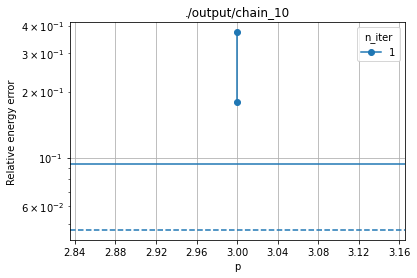

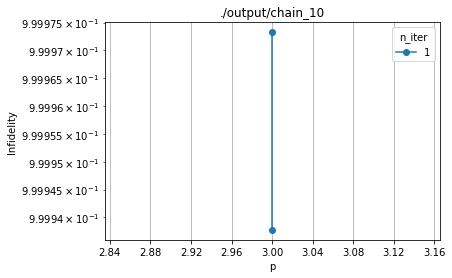

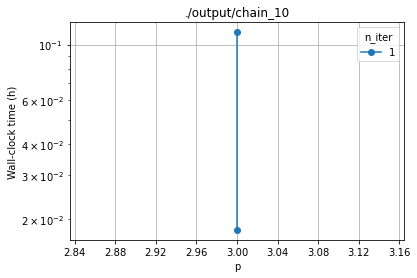

In [18]:
# Write input and results to disk. If no former output exists, print a line explaining the data in the output file.

output=str([vars(cmd_args),vars(run_args),vars(vqe_out)])

if not os.path.exists(output_path+'/output.txt'):
    f=open(output_path+'/output.txt', 'w')
    f.write("### Output of the VQEs is written to this file. Note that the first local minimum is not included in the lists local_min_list,local_min_parameters_list and local_min_accept_list. See the comment at de function definition of 'callback' inside HVQE.py \n")
with open(output_path+'/output.txt', 'a') as f:
    f.write(output+'\n\n')

# Update plot of datapoints
gates_per_cycle=len([edge for layer in run_args.layers for edge in layer])
_HVQE.plot_VQE_data(output_path,'energy',cmd_args.par_multiplicity,gates_per_cycle)
_HVQE.plot_VQE_data(output_path,'infidelity',cmd_args.par_multiplicity,gates_per_cycle)
_HVQE.plot_VQE_data(output_path,'wall_clock',cmd_args.par_multiplicity,gates_per_cycle)

# Write input and results to stdout
print(' ')
print('==========================================================================================')
print('Finished basinhopping of ',output_path, 'at',run_args.date_end,'UTC, with')
print(' ')
print(vars(cmd_args))
print('init_par =', vqe_out.init_par)
print(' ')
print('RESULTS:')
print('--------')
print('E_VQE =',run_args.E_VQE)
print('inf_VQE =',run_args.inf_VQE)
print('n_fn_calls =',vqe_out.n_fn_calls)
print('Wall-clock time', run_args.wall_clock, 'hours')
print(' ')
print('For more output, see',output_path+'/output.txt')
print('Plots of output saved in',output_path)
print('End of HVQE.py')
print('==========================================================================================')
